## Imports

In [1]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import h5py
import matplotlib
import matplotlib.pyplot as plt
import os
from pkg_resources import resource_filename
from matplotlib.colors import LinearSegmentedColormap
import cartopy.crs as ccrs
import xarray as xr
from IPython import embed

# Data Initialization

### OPeNDAPP

In [2]:
opendapp = 'https://opendap.jpl.nasa.gov/opendap/SeaSurfaceTopography/merged_alt/L4/cdr_grid/ssh_grids_v1812_1992100212.nc'
ssh_path = r'C:\Users\btpri\Desktop\ssh_grids_v1812_1992100212.nc'

### parquet

In [3]:
TimerStart = time.perf_counter()

dp_path = r"C:\Users\btpri\OneDrive\Desktop\SSH_std.parquet"
dp = pd.read_parquet(dp_path) # origional table data from parquet
print("origional parquet initialized")

valid_p = np.where(dp.pp_type == 0)
valid_p = dp.iloc[valid_p] # sliced origional data to only be the validation set of data
print("valid parquet initialized")

#                          ⬇ this is the tolerance based on the LL histogram
ex_p = np.where((dp.LL < -1000) & (dp.pp_type == 0))
ex_p = dp.iloc[ex_p] # sliced origional data to only be the extremes of the validation set
print("extreme valid parquet initialized")



TimerStop = time.perf_counter() 
RunTime = TimerStop - TimerStart
print(("total run time: {:.2f} seconds").format(RunTime))

origional parquet initialized
valid parquet initialized
extreme valid parquet initialized
total run time: 2.27 seconds


### h5

In [4]:
TimerStart = time.perf_counter()

ex_idx = np.sort(list(ex_p.pp_idx)) # A list that is the index values for the extreme values
print("index made")
 
dh_path = r"C:\Users\btpri\OneDrive\Desktop\SSH_100clear_32x32.h5"
dh = h5py.File(dh_path, 'r') # origonal data images
print("origional h5 initialized")

#print(list(dh.keys()))
valid_h5 = (dh['valid']) # sliced origional data to only be the validation set of data
print("valid h5 initialized")

# Depending on the tolerance set above, this can take a while
ex_valid = valid_h5[ex_idx] # sliced origional data to only be the extremes of the validation set
print("extreme valid h5 initialized")


TimerStop = time.perf_counter() 
RunTime = TimerStop - TimerStart
print(("total run time: {:.2f} seconds").format(RunTime))

index made
origional h5 initialized
valid h5 initialized
extreme valid h5 initialized
total run time: 0.06 seconds


## Map of Origional Data

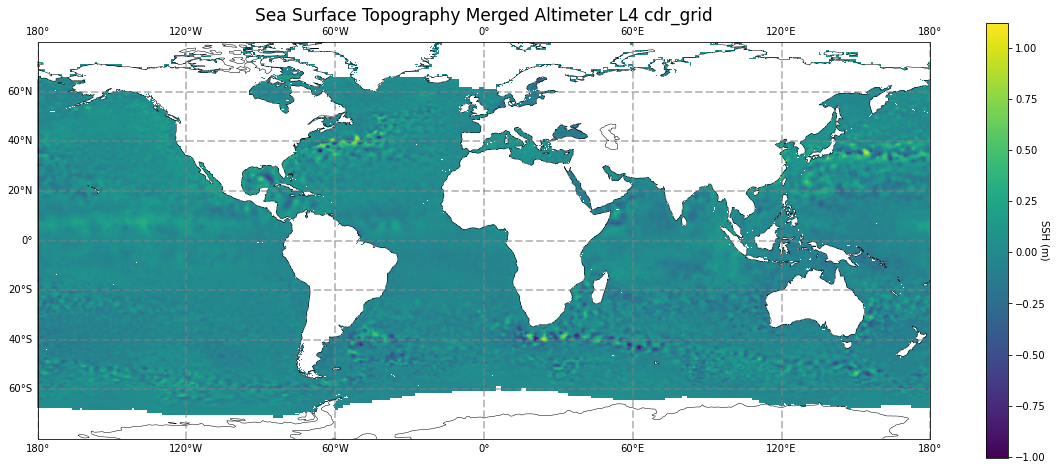

In [5]:
def plot_data(filepath=ssh_path):
    ds = xr.open_dataset(filepath)#.sel(Longitude=slice(minlon, maxlon),Latitude=slice(minlat, maxlat))
  
    # Averages time to make the data 2D. Also transposed the axis because for some reason in the raw data they're flipped
    ds = ds['SLA'].mean(dim="Time").transpose()

    lon = ds.Longitude
    lat = ds.Latitude


    # Initializing the plot
    fig = plt.figure(figsize=(20, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Formatting the title to include information about the plot
    coordinate = str("{0}°N,{1}°E").format(lat,lon) # for formatting the center point to be put into the plot title
    #squaresize = str("{0}x{1}Km").format(sqrsizeKm,sqrsizeKm) # for formatting the plot size to be put into the plot title
    ax.set_title("Sea Surface Topography Merged Altimeter L4 cdr_grid", size=17)
    
    # Setting up the plot
    ax.coastlines(linewidth=0.5)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.right_labels = False
    

   # Making the Color Bar
    #cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
    CF = ax.pcolormesh(ds.Longitude, ds.Latitude, ds, transform=ccrs.PlateCarree()) # need this one for contour color
    cbar = plt.colorbar(CF)#,cax=cax)
    cbar.set_label('SSH (m)', rotation=270)  
    
plot_data()

## SSH Pixel Grid Cut-Outs

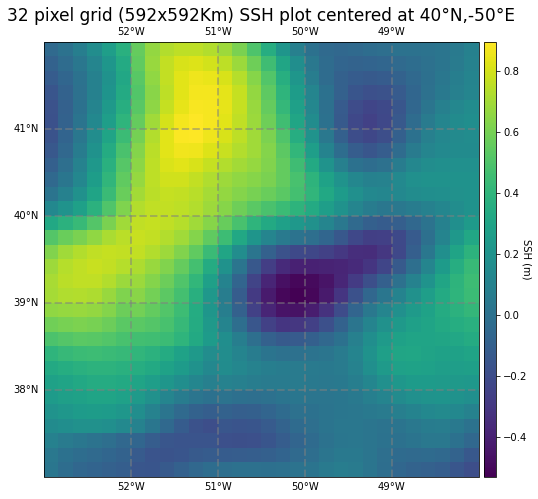

In [6]:
def SSH_cutout(filepath,lat,lon,pixels):

    sqrsizeKm = int(pixels * 18.5) # The data is on a 1/6° grid which is about 18.5 km
    LatLonDeg = (sqrsizeKm / 111) / 2 # This is what will be used to set th eextent of the plot. The "/ 2" is because it adds/subtracts the "radius" from the center point

    # Ceating the bounds to slice the data and set the extent of the plot    
    # Converts °W to °E. Cartopy can use either but the data only takes °E
    if lon < 0:
        lony = lon+360
    else: lony = lon
    
    minlon = abs(int(lony - LatLonDeg))
    maxlon = abs(int(lony + LatLonDeg))
    
    minlat = int(lat - LatLonDeg)
    maxlat = int(lat + LatLonDeg)
    
    # Opening data and slicing spatialy to remove data outside desired bounds
    ds = xr.open_dataset(filepath).sel(Longitude=slice(minlon, maxlon),Latitude=slice(minlat, maxlat))
  
    # Averages time to make the data 2D. Also transposed the axis because for some reason in the raw data they're flipped
    ds = ds['SLA'].mean(dim="Time").transpose()


    # Initializing the plot
    fig = plt.figure(figsize=(8, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())
   
    # Formatting the title to include information about the plot
    coordinate = str("{0}°N,{1}°E").format(lat,lon) # for formatting the center point to be put into the plot title
    squaresize = str("{0}x{1}Km").format(sqrsizeKm,sqrsizeKm) # for formatting the plot size to be put into the plot title
    ax.set_title("{0} pixel grid ({1}) SSH plot centered at {2}".format(pixels,squaresize,coordinate), size=17)
    
    # Setting up the plot
    ax.coastlines(linewidth=0.5)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.right_labels = False
    ax.set_extent([minlon, maxlon, minlat, maxlat], ccrs.PlateCarree()) # left lon bound, right lon bound, top lat bound, bottom lat bound

   # Making the Color Bar
    cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
    CF = ax.pcolormesh(ds.Longitude, ds.Latitude, ds, transform=ccrs.PlateCarree()) # need this one for contour color
    cbar = plt.colorbar(CF,cax=cax)
    cbar.set_label('SSH (m)', rotation=270)
    
SSH_cutout(ssh_path,40,-50,32)

## Imported Function from plotting

In [7]:
def load_palette(pfile=None):
    """ Load the color pallette

    Args:
        pfile (str, optional): Filename of the pallette. Defaults to None.

    Returns:
        color pallette, LinearSegmentedColormap: pallette for sns, colormap
    """
    
    if pfile is None:
        pfile = os.path.join(resource_filename('ulmo', 'plotting'), 'color_palette.txt')
    # Load me up
    with open(pfile, 'r') as f:
        colors = np.array([l.split() for l in f.readlines()]).astype(np.float32)
        pal = sns.color_palette(colors)
        boundaries = np.linspace(0, 1, 64)
        colors = list(zip(boundaries, colors))
        cm = LinearSegmentedColormap.from_list(name='rainbow', colors=colors)
    return pal, cm

def show_image(img:np.ndarray, cm=None, cbar=True, flipud=True,
               vmnx=(None,None), show=False, set_aspect=None):
    """Dispay the cutout image

    Args:
        img (np.ndarray): cutout image
        cm ([type], optional): Color map to use. Defaults to None.
            If None, load the heatmap above
        cbar (bool, optional): If True, show a color bar. Defaults to True.
        flipud (bool, optional): If True, flip the image up/down. Defaults to True.
        vmnx (tuple, optional): Set vmin, vmax. Defaults to None
        set_aspect (str, optional):
            Passed to ax.set_aspect() if provided

    Returns:
        matplotlib.Axis: axis containing the plot
    """
    if cm is None:
        _, cm = load_palette()
    #
    ax = sns.heatmap(np.flipud(img), xticklabels=[], 
                     vmin=vmnx[0], vmax=vmnx[1],
                     yticklabels=[], cmap=cm, cbar=cbar)
    if show:
        plt.show()
    if set_aspect is not None:
        ax.set_aspect(set_aspect)
    #
    return ax

## LL Histogram

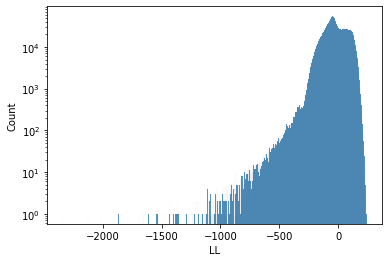

In [8]:
def LL_hist(dp=dp,logy=False):
    '''Makes the LL plot. If logy is set to true it will log the y-axis. Set to False by default.'''
    dp_plot = sns.histplot(dp, x="LL")
    
    if logy ==True:
        dp_plot.set_yscale('log')
        
LL_hist(logy=True)

## Shorten h5 File

In [9]:
def shorten_h5(ds, n, stats=False):
        """Shortens an array, ds, based on the first index to the length n.
        If stats is set to True it will print additional information; stats is False by default."""
        if stats == True:
            print('preshorten ', ds)
            print('preshorten length ', len(ds))
            print('preshorten shape ',ds.shape)
            print('')
            
        r = np.random.choice(len(ds), n)
        rs = np.sort(r)
        ds = ds[rs]
        
        if stats == True:
            print('short length ', len(ds))
            print('short shape ',ds.shape)
            print('')
            
        return ds

## Shorten parquet File

In [10]:
def shorten_parquet(num, ds, stats=False):
        """Shortens an array, ds, based on the first index to the length n.
        If stats is set to True it will print additional information; stats is False by default."""
        #print(ds)
        if stats == True:
            #print('preshorten ', ds)
            print('preshorten length ', len(ds))
            print('preshorten shape ',ds.shape)
            print('')
            
        ds = dp.sample(n=num)
        
        if stats == True:
            print('short length ', len(ds))
            print('short shape ',ds.shape)
            print('')
            
        return ds
    
(shorten_parquet(1000, valid_p, True)).head()
print("")
#valid_p

preshorten length  7449792
preshorten shape  (7449792, 19)

short length  1000
short shape  (1000, 19)




## Extreme SubFields

C:\Users\btpri\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


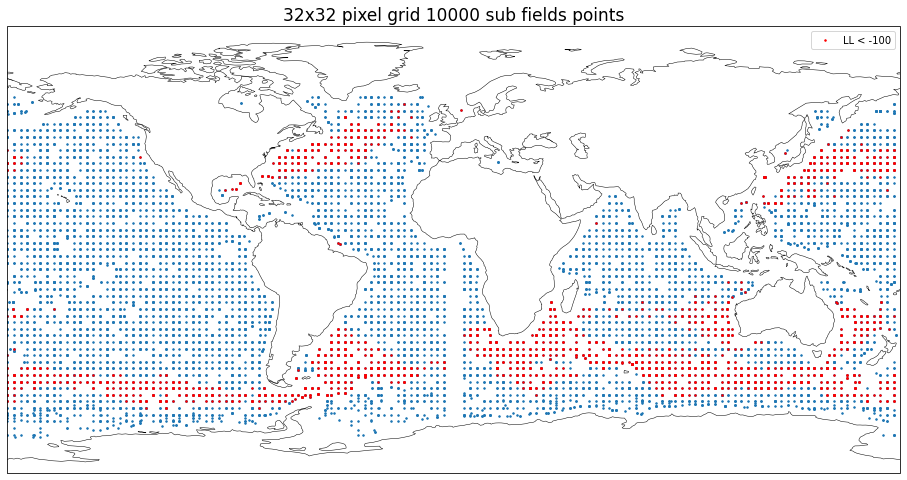

In [11]:
def extreme_subfields(ds, points, tolerance):
    
    """Plots subfield positions and distinguishes the extremes. Takes data, 
    the amount of points to plot and a tolerance level based on the LL histogram."""
    
    ds = shorten_parquet(points, ds)
    
    lats = ds.lat    
    lons = ds.lon

    extremes = np.where(ds.LL < tolerance)
    extremes = ds.iloc[extremes]

    exlats = extremes.lat
    exlons = extremes.lon

    # Fixing the coordinates so it displays all the points
    for i in range(len(lons)):
        if lons.iloc[i] >= 180:
            lons.iloc[i] = lons.iloc[i]-360

    for i in range(len(exlons)):
        if exlons.iloc[i] >= 180:
            exlons.iloc[i] = exlons.iloc[i]-360
            
    #ex_LL = (np.sqrt((extremes.LL)**2))
    #ex_LL = (ex_LL/ex_LL.max())
    #print(ex_LL)

    
    

    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
    fig.set_size_inches([16,16])
    ax.set_title("32x32 pixel grid {} sub fields points".format(points), size=17)
    ax.set_global()
    ax.coastlines(linewidth=0.5)
    ax.plot(lons, lats, '.', markersize = 3)
    ax.plot(exlons, exlats, '.', markersize = 3, color = 'r', label="LL < {}".format(tolerance))
    ax.legend()
    
extreme_subfields(valid_p, 10000, -100)

## Extreme Subfields Colormap

total run time: 0.26 seconds


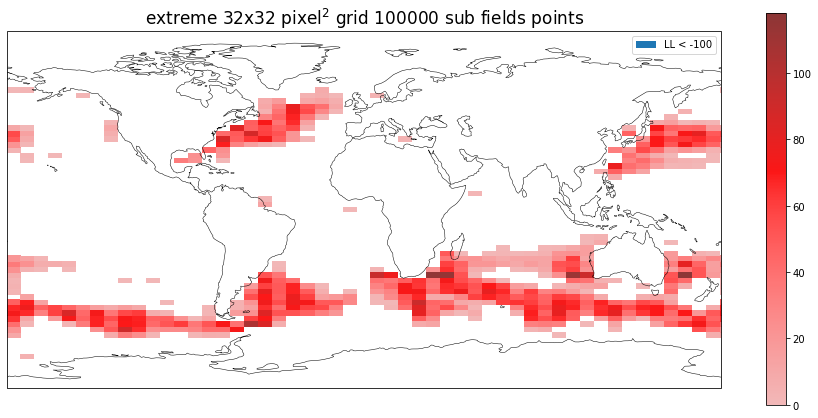

In [12]:
TimerStart = time.perf_counter()


def exsubcolor(points, tolerance, ds=valid_p, ex=False):
    
    ds = shorten_parquet(points, ds)
    
    norm = np.where(ds.LL > tolerance)
    norm = ds.iloc[norm]
    lats = norm.lat    
    lons = norm.lon

    extremes = np.where(ds.LL < tolerance)
    extremes = ds.iloc[extremes]
    exlats = extremes.lat
    exlons = extremes.lon
    
    
    #color = (np.sqrt((ds.LL)**2))
    #color = (color/color.max())
    #color = np.nan_to_num(color)
    #print(len(color))
    #print(len(ds.lon))
    #print(len(ds.lat))
    
    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
    fig.set_size_inches([16,16])
    
    ax.set_global()
    ax.coastlines(linewidth=0.5)

    
    if ex == True:
        ax.set_title("extreme 32x32 pixel$^2$ grid {} sub fields points".format(points), size=17)
        sns.histplot(ds.LL,x=exlons,y=exlats, color="r", bins=50, legend=False, cbar=True, cbar_kws=dict(shrink=.45), label="LL < {}".format(tolerance))
    else:
        ax.set_title("nonextreme 32x32 pixel$^2$ grid {} sub fields points".format(points), size=17)
        sns.histplot(ds.LL,x=lons,y=lats, bins=50, color="b", legend=False, cbar=True, cbar_kws=dict(shrink=.45), label="LL > {}".format(tolerance))
    
    ax.legend()

exsubcolor(100000, -100, ex=True)

TimerStop = time.perf_counter() 
RunTime = TimerStop - TimerStart
print(("total run time: {:.2f} seconds").format(RunTime))

total run time: 0.35 seconds


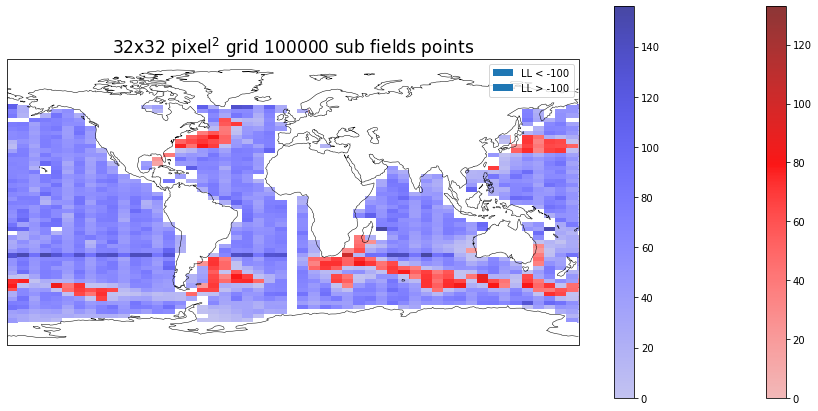

In [13]:
TimerStart = time.perf_counter()


def allsubcolor(points, tolerance, ds=valid_p):
    
    ds = shorten_parquet(points, ds)
    
    norm = np.where(ds.LL > tolerance)
    norm = ds.iloc[norm]
    lats = norm.lat    
    lons = norm.lon

    extremes = np.where(ds.LL < tolerance)
    extremes = ds.iloc[extremes]
    exlats = extremes.lat
    exlons = extremes.lon
    
    
    #color = (np.sqrt((ds.LL)**2))
    #color = (color/color.max())
    #color = np.nan_to_num(color)
    #print(len(color))
    #print(len(ds.lon))
    #print(len(ds.lat))
    
    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
    fig.set_size_inches([16,16])
    ax.set_title("32x32 pixel$^2$ grid {} sub fields points".format(points), size=17)
    ax.set_global()
    ax.coastlines(linewidth=0.5)
    

    sns.histplot(ds.LL,x=exlons,y=exlats, color="r", bins=50, legend=False, cbar=True, cbar_kws=dict(shrink=.45), label="LL < {}".format(tolerance))

    sns.histplot(ds.LL,x=lons,y=lats, bins=50, color="b", legend=False, cbar=True, cbar_kws=dict(shrink=.45), label="LL > {}".format(tolerance))

    ax.legend()
    
allsubcolor(100000, -100)

TimerStop = time.perf_counter() 
RunTime = TimerStop - TimerStart
print(("total run time: {:.2f} seconds").format(RunTime))

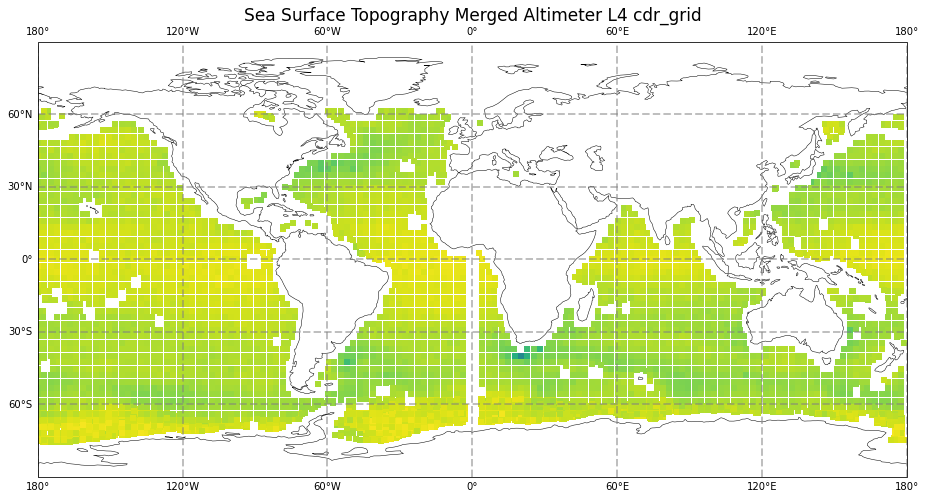

In [14]:
def plot_output(ds=valid_p):
    #ds = xr.open_dataset(filepath)#.sel(Longitude=slice(minlon, maxlon),Latitude=slice(minlat, maxlat))
  
    # Averages time to make the data 2D. Also transposed the axis because for some reason in the raw data they're flipped
    #ds = ds['SLA'].mean(dim="Time").transpose()

    ds = shorten_parquet(1000000, ds)
    
    lon = ds.lon
    lat = ds.lat




   
    
    # Initializing the plot
    fig = plt.figure(figsize=(20, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Formatting the title to include information about the plot
    #coordinate = str("{0}°N,{1}°E").format(lat,lon) # for formatting the center point to be put into the plot title
    #squaresize = str("{0}x{1}Km").format(sqrsizeKm,sqrsizeKm) # for formatting the plot size to be put into the plot title
    ax.set_title("Sea Surface Topography Merged Altimeter L4 cdr_grid", size=17)
    
    # Setting up the plot
    ax.coastlines(linewidth=0.5)
    ax.set_global()
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.right_labels = False
    

   # Making the Color Bar
    #cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
    
    #ax.pcolormesh(lon, lat, ds.LL, transform=ccrs.PlateCarree()) # need this one for contour color
    
    ax.scatter(lon, lat, c=ds.LL, marker=',', linewidths=0, transform=ccrs.PlateCarree()) # need this one for contour color
    
    #ax.imshow((lat,lon,ds.LL))
    
    #cbar = plt.colorbar(CF)#,cax=cax)
    #cbar.set_label('SSH (m)', rotation=270)  
    
plot_output()